# context 

This script performs the final prediction using the LSTM model selected during the model‐selection phase. It also implements our chosen strategies by fetching fresh data directly from the API, making the script fully self‐contained and runnable at any time to have recent strategy.

# Imports

In [0]:
%pip install tensorflow

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay

from pyspark.sql import SparkSession, Window, Row
from pyspark.sql.types import StructType, StructField, DateType, DoubleType
from pyspark.sql.functions import (
    col, to_date, lag, avg, stddev, log, when, current_date,
    date_sub, add_months, expr, row_number, dayofweek, lit, desc
)


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.metrics import RootMeanSquaredError

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pyspark.sql.functions import col, lead, when
from pyspark.sql.window import Window

In [0]:
symbol =  "AAPL"
api_key = "UDEJQ3FLFIY9BVVT"

In [0]:
def get_alpha_vantage_data(symbol, key):
    function = 'TIME_SERIES_DAILY'
    output_size = 'full'
    url = f'https://www.alphavantage.co/query?function={function}&symbol={symbol}&outputsize={output_size}&apikey={key}'

    r = requests.get(url)
    data = r.json()

    if 'Time Series (Daily)' in data:
        df = pd.DataFrame(data['Time Series (Daily)']).T
        df.index = pd.to_datetime(df.index)
        df.sort_index(inplace=True)
        df.columns = [col.split('. ')[1] for col in df.columns]
        df = df.apply(pd.to_numeric)
        df = df[df.index >= datetime.now() - timedelta(days=365*20)]

        df.reset_index(inplace=True)
        df.rename(columns={'index': 'Date'}, inplace=True)
        return spark.createDataFrame(df)
    else:
        raise Exception("Alpha Vantage API Error")

In [0]:
spark_df = get_alpha_vantage_data(symbol, api_key)

In [0]:
splits = {
    '2005-02-28': 2, # two-for-one stock split on 28 February 2005
    '2014-06-09': 7, #  seven-for-one stock split on 9th of June 2014
    '2020-08-31': 4. #  four-for-one stock split on 31st of August 2020
}

for split_date_str, stock_split in splits.items():
    split_date = datetime.strptime(split_date_str, "%Y-%m-%d")
    
    # Adjust prices before split date
    spark_df = spark_df.withColumn(
        'open',
        when(col('Date') < lit(split_date), col('open') / stock_split).otherwise(col('open'))
    ).withColumn(
        'high',
        when(col('Date') < lit(split_date), col('high') / stock_split).otherwise(col('high'))
    ).withColumn(
        'low',
        when(col('Date') < lit(split_date), col('low') / stock_split).otherwise(col('low'))
    ).withColumn(
        'close',
        when(col('Date') < lit(split_date), col('close') / stock_split).otherwise(col('close'))
    ).withColumn(
        'volume',
        when(col('Date') < lit(split_date), col('volume') * stock_split).otherwise(col('volume'))
    )



# Final Prediction

We use the LSTM model chosen during model selection. Because Spark ML doesn’t support LSTMs, we:

1. Convert the Spark DataFrame to pandas  
2. Run the LSTM predictions in pandas  
3. Convert the pandas results back into a Spark DataFrame  

**What’s changed**

- **Larger window size**  
  The model now looks further back in time to capture more variation.

- **Dropout layer**  
  Added dropout to improve generalization and reduce overfitting.

- **One-shot dense output**  
  A Dense layer predicts the entire forecast horizon at once, avoiding rolling forecasts.

 

In [0]:
# represent the number of business days in a year
window_size = 252
horizon = 252

spark_df = spark_df.select("date", "close")
spark_df = spark_df.withColumn("date", to_date(col("date"), "yyyy-MM-dd"))
training_pdf = spark_df.toPandas()

train_vals = training_pdf["close"].values.reshape(-1,1)
scaler = MinMaxScaler()
scaled_all = scaler.fit_transform(train_vals).flatten()

Epoch 1/10
128/128 [==============================] - 17s 119ms/step - loss: 0.0106 - rmse: 0.1032 - val_loss: 0.0240 - val_rmse: 0.1549
Epoch 2/10
 26/128 [=====>........................] - ETA: 10s - loss: 0.0026 - rmse: 0.0510

*** WARNING: max output size exceeded, skipping output. ***

128/128 [==============================] - 13s 98ms/step - loss: 0.0013 - rmse: 0.0361 - val_loss: 0.0236 - val_rmse: 0.1537
Epoch 10/10
1/1 [==============================] - 0s 392ms/step


INFO:tensorflow:Assets written to: /tmp/tmp40zcai00/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp40zcai00/model/data/model/assets


1/1 [==============================] - 0s 30ms/step


/databricks/python/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


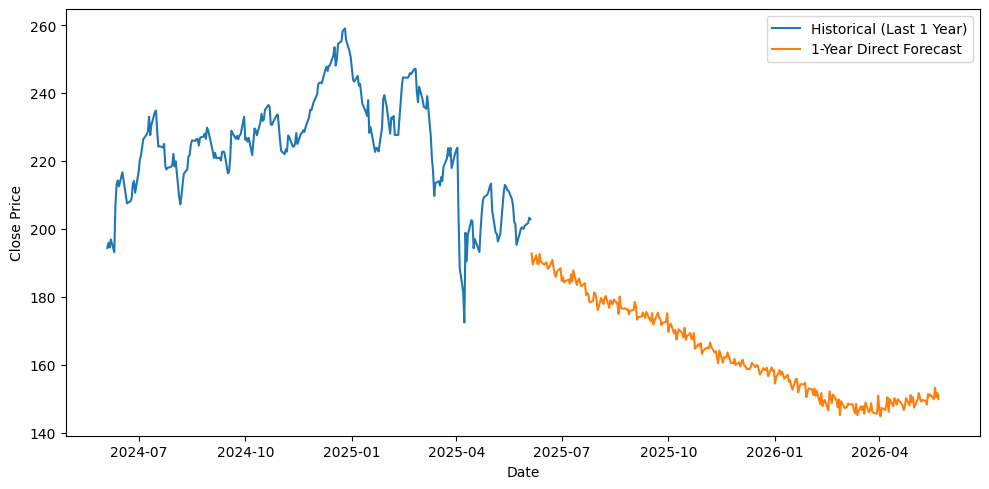

In [0]:
# Create sliding windows
X, Y = [], []
for i in range(len(scaled_all) - window_size - horizon + 1):
    X.append(scaled_all[i : i + window_size])
    Y.append(scaled_all[i + window_size : i + window_size + horizon])
X = np.array(X).reshape(-1, window_size, 1)  # (samples, window_size, 1)
Y = np.array(Y)                              # (samples, horizon)

# model definition 
model = Sequential([
    LSTM(64, input_shape=(window_size, 1)),
    Dropout(0.2),
    Dense(horizon)      # predict `horizon` steps at once
])

model.compile(optimizer="adam", loss="mse", metrics=[RootMeanSquaredError(name="rmse")])
history = model.fit(
    X, Y,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# Predict on the last window
last_window = scaled_all[-window_size:].reshape(1, window_size, 1)
pred_scaled = model.predict(last_window)[0]

# 5) Inverse scale forecasts
pred_prices = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()

# 6) Prepare dates
last_date = training_pdf["date"].iloc[-1]
future_dates = pd.bdate_range(start=last_date + BDay(1), periods=horizon)

# 7) Plot only the last year of actual data
one_year_ago = last_date - pd.DateOffset(years=1)
mask_recent  = training_pdf["date"] >= one_year_ago

plt.figure(figsize=(10, 5))
plt.plot(
    training_pdf.loc[mask_recent, "date"],
    training_pdf.loc[mask_recent, "close"],
    label="Historical (Last 1 Year)"
)
plt.plot(future_dates, pred_prices, label="1-Year Direct Forecast")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()

In [0]:
out = pd.concat([training_pdf, pd.DataFrame({"date": future_dates, "close": pred_prices})], ignore_index=True)
spark_df = spark.createDataFrame(out)
spark_df.orderBy(desc("date")).limit(20).orderBy("date").show()

+----------+------------------+
|      date|             close|
+----------+------------------+
|2026-04-27|147.99342346191406|
|2026-04-28|151.02540588378906|
|2026-04-29| 148.9082489013672|
|2026-04-30|150.40713500976562|
|2026-05-01|147.32879638671875|
|2026-05-04|149.65879821777344|
|2026-05-05|151.64285278320312|
|2026-05-06|150.20150756835938|
|2026-05-07|149.14852905273438|
|2026-05-08| 149.5924530029297|
|2026-05-11| 149.3689727783203|
|2026-05-12| 148.2152099609375|
|2026-05-13|151.37100219726562|
|2026-05-14|150.65953063964844|
|2026-05-15|  151.231689453125|
|2026-05-18| 149.8352813720703|
|2026-05-19|153.21937561035156|
|2026-05-20|    150.3759765625|
|2026-05-21|     151.748046875|
|2026-05-22| 149.8193817138672|
+----------+------------------+



### Strategies Advice


In [0]:
# Step 1: Set your known last historical date
last_actual_date = training_pdf["date"].max()
print(f"Last historical date: {last_actual_date}")

# Step 2: Only use forecasted part
forecast_df = spark_df.filter(col("date") > lit(last_actual_date))

# Step 3: Define strategy offsets
strategy_windows = {
    "daily": 1,
    "monthly": 21,
    "quarterly": 63,
    "yearly": 252
}

# Step 4: Count total number of forecasted rows
forecast_count = forecast_df.count()

# Step 5: Apply strategy logic on all forecast rows, best-effort
for name, offset in strategy_windows.items():
    actual_offset = min(offset, forecast_count - 1)  # limit offset to available rows

    future_col = f"future_price_{name}"
    return_col = f"return_{name}"
    advice_col = f"{name}_advice"

    # Add lead column
    spark_df = spark_df.withColumn(future_col, lead("close", actual_offset).over(Window.orderBy("date")))

    # Compute return
    spark_df = spark_df.withColumn(
        return_col,
        ((col(future_col) - col("close")) / col("close")) * 100
    )

    # Thresholds
    if name == "daily":
        buy, sell = 2.5, -2.5
    elif name == "monthly":
        buy, sell = 5.0, -3.0
    elif name == "quarterly":
        buy, sell = 8.0, -5.0
    elif name == "yearly":
        buy, sell = 15.0, -10.0

    # Advice only on predictions
    spark_df = spark_df.withColumn(
        advice_col,
        when(col("date") > lit(last_actual_date),
             when(col(return_col) >= buy, "Buy")
             .when(col(return_col) <= sell, "Sell")
             .otherwise("Hold")
        )
    )

# Final selection: forecast only with advice
advice_cols = ["date", "close"] + [f"{k}_advice" for k in strategy_windows]
strategy_df = spark_df.select(*advice_cols).filter(col("date") > lit(last_actual_date))
strategy_df.show(50, truncate=False)

Last historical date: 2025-06-04
+----------+------------------+------------+--------------+----------------+-------------+
|date      |close             |daily_advice|monthly_advice|quarterly_advice|yearly_advice|
+----------+------------------+------------+--------------+----------------+-------------+
|2025-06-05|192.75987243652344|Hold        |Sell          |Sell            |Sell         |
|2025-06-06|189.51815795898438|Hold        |Hold          |Sell            |Hold         |
|2025-06-09|192.1876678466797 |Hold        |Sell          |Sell            |Hold         |
|2025-06-10|189.6656951904297 |Hold        |Hold          |Sell            |Hold         |
|2025-06-11|189.6504364013672 |Hold        |Hold          |Sell            |Hold         |
|2025-06-12|192.54949951171875|Hold        |Hold          |Sell            |Hold         |
|2025-06-13|190.28488159179688|Hold        |Sell          |Sell            |Hold         |
|2025-06-16|189.42373657226562|Hold        |Hold         

#### Top 50 latest dates

In [0]:
strategy_df.orderBy(col("date").desc()).show(50, truncate=False)


+----------+------------------+------------+--------------+----------------+-------------+
|date      |close             |daily_advice|monthly_advice|quarterly_advice|yearly_advice|
+----------+------------------+------------+--------------+----------------+-------------+
|2026-05-22|149.8193817138672 |Hold        |Hold          |Hold            |Hold         |
|2026-05-21|151.748046875     |Hold        |Hold          |Hold            |Hold         |
|2026-05-20|150.3759765625    |Hold        |Hold          |Hold            |Hold         |
|2026-05-19|153.21937561035156|Hold        |Hold          |Hold            |Hold         |
|2026-05-18|149.8352813720703 |Hold        |Hold          |Hold            |Hold         |
|2026-05-15|151.231689453125  |Hold        |Hold          |Hold            |Hold         |
|2026-05-14|150.65953063964844|Hold        |Hold          |Hold            |Hold         |
|2026-05-13|151.37100219726562|Hold        |Hold          |Hold            |Hold         |

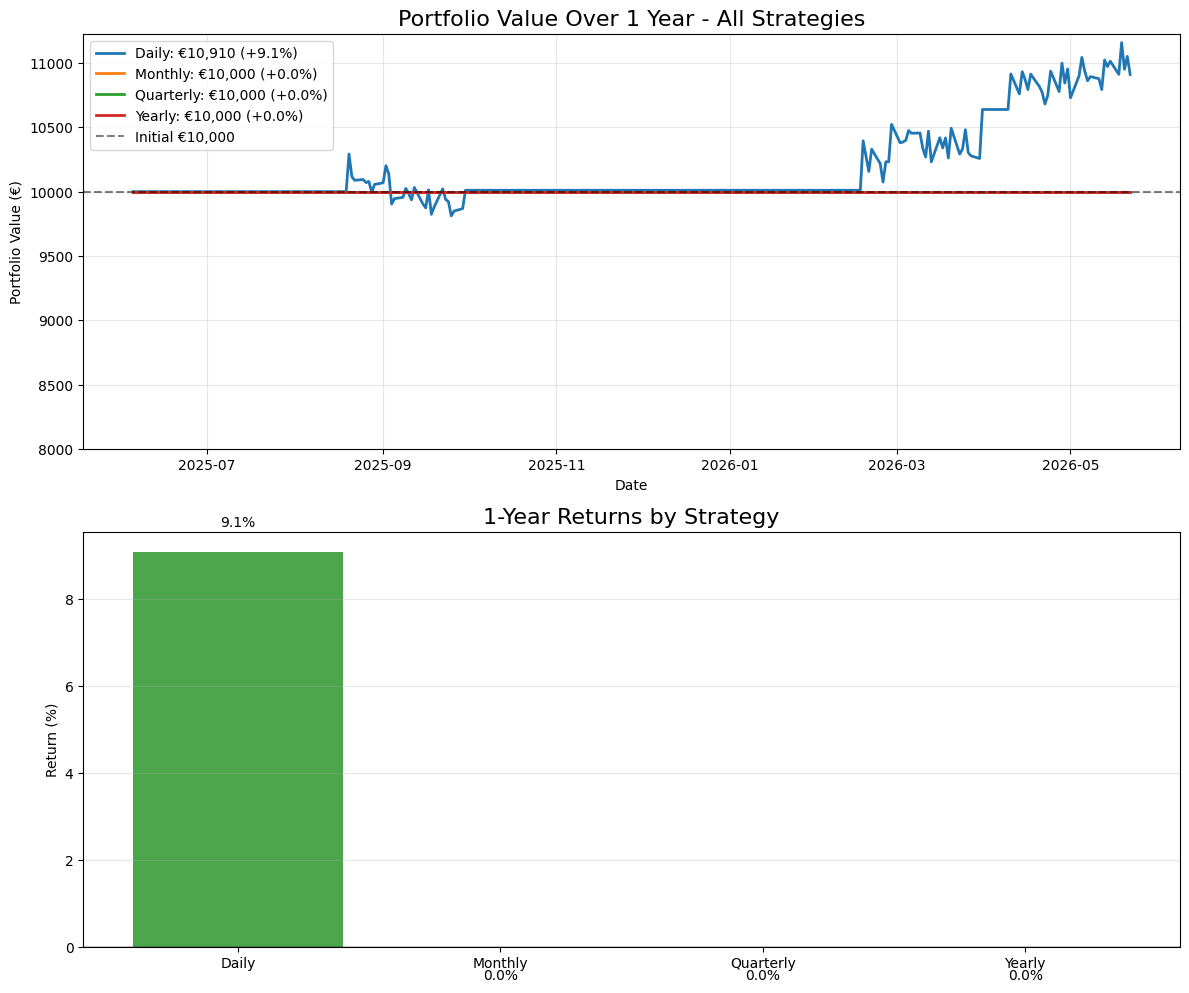

=== 1-YEAR INVESTMENT SIMULATION RESULTS ===

Initial Investment: €10,000
Period: 2025-06-05 to 2026-05-22
Stock: AAPL

Strategy     Final Value     Return       Trades    
Daily        €    10,909.78        9.1%        7
Monthly      €    10,000.00        0.0%        0
Quarterly    €    10,000.00        0.0%        0
Yearly       €    10,000.00        0.0%        0
----------------------------------------------------------------------
Buy & Hold   €     7,772.33      -22.3%        0

=== FIRST TRADE TIMING ===
Daily: BUY on 2025-08-19 at $174.93
Monthly: No trades executed
Quarterly: No trades executed
Yearly: No trades executed


In [0]:
# Investment Simulation Using Your Existing Strategy
# This uses the strategy_df you already created with advice columns

# Convert strategy_df to pandas for simulation
simulation_df = strategy_df.orderBy("date").toPandas()
simulation_df['date'] = pd.to_datetime(simulation_df['date'])

# Investment parameters
initial_investment = 10000
strategies = ['daily', 'monthly', 'quarterly', 'yearly']

# Store results for each strategy
results = {}

# Run simulation for each strategy
for strategy in strategies:
    advice_col = f"{strategy}_advice"
    
    # Initialize portfolio
    cash = initial_investment
    shares = 0
    portfolio_values = []
    trades = []
    
    # Simulate trading for one year
    for idx, row in simulation_df.iterrows():
        date = row['date']
        price = row['close']
        advice = row[advice_col]
        
        # Execute trades based on advice
        if advice == "Buy" and cash > 0:
            # Buy with all available cash
            shares = cash / price
            cash = 0
            trades.append({'date': date, 'action': 'BUY', 'price': price})
            
        elif advice == "Sell" and shares > 0:
            # Sell all shares
            cash = shares * price
            shares = 0
            trades.append({'date': date, 'action': 'SELL', 'price': price})
        
        # Calculate current portfolio value
        portfolio_value = cash + (shares * price)
        portfolio_values.append(portfolio_value)
    
    # Calculate final results
    final_value = portfolio_values[-1]
    total_return = ((final_value - initial_investment) / initial_investment) * 100
    
    results[strategy] = {
        'portfolio_values': portfolio_values,
        'final_value': final_value,
        'total_return': total_return,
        'num_trades': len(trades),
        'trades': trades
    }

# Create visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Portfolio values over time
for strategy in strategies:
    data = results[strategy]
    ax1.plot(simulation_df['date'], data['portfolio_values'], 
             label=f"{strategy.capitalize()}: €{data['final_value']:,.0f} ({data['total_return']:+.1f}%)", 
             linewidth=2)

ax1.axhline(y=initial_investment, color='black', linestyle='--', alpha=0.5, label='Initial €10,000')
ax1.set_title('Portfolio Value Over 1 Year - All Strategies', fontsize=16)
ax1.set_xlabel('Date')
ax1.set_ylabel('Portfolio Value (€)')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(bottom=8000)  # Set minimum to see all lines clearly

# Plot 2: Returns comparison
returns_data = [results[s]['total_return'] for s in strategies]
colors = ['green' if r > 0 else 'red' for r in returns_data]

bars = ax2.bar([s.capitalize() for s in strategies], returns_data, color=colors, alpha=0.7)
ax2.set_title('1-Year Returns by Strategy', fontsize=16)
ax2.set_ylabel('Return (%)')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, ret in zip(bars, returns_data):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., 
             height + (0.5 if height > 0 else -0.5),
             f'{ret:.1f}%', 
             ha='center', 
             va='bottom' if height > 0 else 'top')

plt.tight_layout()
plt.show()

# Print summary table
print("=== 1-YEAR INVESTMENT SIMULATION RESULTS ===")
print(f"\nInitial Investment: €{initial_investment:,}")
print(f"Period: {simulation_df['date'].iloc[0].strftime('%Y-%m-%d')} to {simulation_df['date'].iloc[-1].strftime('%Y-%m-%d')}")
print(f"Stock: AAPL")
print("\n" + "="*70)
print(f"{'Strategy':<12} {'Final Value':<15} {'Return':<12} {'Trades':<10}")
print("="*70)

for strategy in strategies:
    data = results[strategy]
    print(f"{strategy.capitalize():<12} €{data['final_value']:>13,.2f} {data['total_return']:>10.1f}% {data['num_trades']:>8}")

# Add buy-and-hold comparison
buy_hold_final = initial_investment * (simulation_df['close'].iloc[-1] / simulation_df['close'].iloc[0])
buy_hold_return = ((buy_hold_final - initial_investment) / initial_investment) * 100
print("-"*70)
print(f"{'Buy & Hold':<12} €{buy_hold_final:>13,.2f} {buy_hold_return:>10.1f}% {0:>8}")

# Show when first trades happen for each strategy
print("\n=== FIRST TRADE TIMING ===")
for strategy in strategies:
    if results[strategy]['trades']:
        first_trade = results[strategy]['trades'][0]
        print(f"{strategy.capitalize()}: {first_trade['action']} on {first_trade['date'].strftime('%Y-%m-%d')} at ${first_trade['price']:.2f}")
    else:
        print(f"{strategy.capitalize()}: No trades executed")